# Molecular Isotopic Distributions Part 2: Combinations

In [8]:
%%capture
%!pip install rdkit
%!pip install mendeleev

In [35]:
from collections import defaultdict
import math
import copy

from IPython.display import display, Markdown
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

from mendeleev import element
from rdkit import Chem
from rdkit.Chem import Descriptors

In [36]:
# Carbon tetrachloride
sml = "ClC(Cl)(Cl)Cl"
mol = Chem.MolFromSmiles(sml)

In [54]:
class MolecularIsotope():
  """Store a molecule's isotopic properties."""
  def __init__(
      self,
      sml: str,
      mol: Chem.rdchem.Mol = None,
      abundance: float = None):
    self.sml = sml
    self.abundance = abundance
    if mol is not None:
      self.mol = mol
    else:
      try:
        self.mol = Chem.MolFromSmiles(sml)
      except:
        self.mol = Chem.MolFromSmiles(sml, sanitize=False)
  def update(self):
    self.mass = Descriptors.ExactMolWt(self.mol)
    self.canon_sml = Chem.MolToSmiles(self.mol)
  def get_mass(self):
    return self.mass

In [38]:
#? Replace with newer version?
def composition(molecule):
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and any charge.
    For example, fluoride ion (chemical formula F-, SMILES string [F-])
    returns {9: 1, 0: -1}.

    :param molecule: The molecule to analyze
    :type some_input: An RDKit molecule
    :rtype: A dictionary.
    """
    # Check that there is a valid molecule
    if molecule:

        # Add hydrogen atoms--RDKit excludes them by default
        molecule_with_Hs = Chem.AddHs(molecule)
        comp = defaultdict(lambda: 0)

        # Get atom counts
        for atom in molecule_with_Hs.GetAtoms():
            comp[atom.GetSymbol()] += 1

        return comp


In [39]:
def flatten_ndarray(arr):
    flat_list = []
    for element in arr:
        if isinstance(element, np.ndarray):
            flat_list.extend(flatten_ndarray(element))
        else:
            flat_list.append(element)
    return flat_list

In [40]:
def binomial_coefficient(n, k):
    return math.factorial(n) // (math.factorial(k) * math.factorial(n - k))

In [41]:
def distribute_items(n, k):
    def backtrack(remaining_items, bins, current_bin):
        if current_bin == k:
            if remaining_items == 0:
                results.append(list(bins))
            return

        for items_in_current_bin in range(remaining_items + 1):
            bins[current_bin] = items_in_current_bin
            backtrack(remaining_items - items_in_current_bin, bins, current_bin + 1)

    results = []
    bins = [0] * k
    backtrack(n, bins, 0)
    return results

In [42]:
#? Replace with newer version?
def atom_set(molecule):
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and any charge.
    For example, fluoride ion (chemical formula F-, SMILES string [F-])
    returns {9: 1, 0: -1}.

    :param molecule: The molecule to analyze
    :type some_input: An RDKit molecule
    :rtype: A dictionary.
    """
    # Check that there is a valid molecule
    if molecule:
      # Add hydrogen atoms--RDKit excludes them by default
      molecule_with_Hs = Chem.AddHs(molecule)
      atom_symbols = set(atom.GetSymbol() for atom in molecule_with_Hs.GetAtoms())
      return atom_symbols

In [43]:
set_of_atoms = atom_set(mol)
print(set_of_atoms)
isotopes = {}
for atom in set_of_atoms:
  # print(f"{atom=}")
  # print(f"{element(atom)=}")
  element_isotopes = element(atom).isotopes
  occuring_isotopes = [[isotope.mass_number, isotope.abundance/100] for isotope in element_isotopes if isotope.abundance != None]
  isotopes[atom] = occuring_isotopes
print(isotopes)

{'Cl', 'C'}
{'Cl': [[35, 0.758], [37, 0.242]], 'C': [[12, 0.9894], [13, 0.0106]]}


In [44]:
def print_ndarray_elements(arr, prefix=''):
    if isinstance(arr, Chem.Mol):
        print(prefix + Chem.MolToSmiles(arr))
    else:
        for i in range(len(arr)):
            new_prefix = prefix + "[" + str(i) + "]"
            print_ndarray_elements(arr[i], new_prefix)

In [45]:
def extract_properties(arr, prop_name):
    if isinstance(arr, np.ndarray):
        # If arr is a NumPy ndarray, iterate through its elements and apply the function recursively
        return np.array([extract_properties(item, prop_name) for item in arr])
    elif isinstance(arr, list):
        # If arr is a list, iterate through its elements and apply the function recursively
        return [extract_properties(item, prop_name) for item in arr]
    elif hasattr(arr, prop_name):
        # If arr has the specified property, extract its value
        return getattr(arr, prop_name)
    else:
        # If the property is not found, return None
        return None

In [46]:
def assign_isotopes(
      arr, 
      isotope_count_distribution, 
      prefix, 
      n_this_element,
      ):
    if isinstance(arr, np.ndarray):
        for i in range(len(arr)):
            new_prefix = prefix + [i]
            assign_isotopes(arr[i], isotope_count_distribution, new_prefix, n_this_element)
    else:
        # Clone the distribution, making it independent so the next loop won't be affected
        distribution = copy.deepcopy(isotope_count_distribution[prefix[0]])

        # Calculate abundances
        if arr.abundance is None:
           arr.abundance = 1
        a = 1
        b = binomial_coefficient(n_this_element, distribution[0])
        for isotope_index, isotope_count in enumerate(distribution):
          a_this_isotope = isotopes[this_element][isotope_index][1]
          a *= a_this_isotope**isotope_count
        arr.abundance *= a*b

        # print(f"{distribution=}")
        # Assign isotopes to atoms of this element type
        for atom_index, atom in enumerate(arr.mol.GetAtoms()):
          if atom.GetSymbol() == this_element:
            # Count down each isotope, going on to the next when zero
            for isotope_index, isotope in enumerate(distribution):
              # print(f"    {isotope_index=}")
              if distribution[isotope_index] > 0:
                  atom.SetIsotope(isotopes[this_element][isotope_index][0])
                  distribution[isotope_index] -= 1

        isotopes_list = []
        for atom_index, atom in enumerate(arr.mol.GetAtoms()):
          isotopes_list.append(atom.GetIsotope())
        isotopes_str = ','.join(map(str, isotopes_list))
        # print("".join([f"[{i}]" for i in prefix]) + Chem.MolToSmiles(arr.mol) + isotopes_str)
    return arr

In [47]:
def update_molecular_isotopes(
      arr, 
      ):
    if isinstance(arr, np.ndarray):
        for i in range(len(arr)):
            update_molecular_isotopes(arr[i])
    elif isinstance(arr, MolecularIsotope):
        arr.update()

In [48]:
# Initialize ndarray to hold MolecularIsotope objects
molecular_isotopes:np.ndarray = np.array(MolecularIsotope)

# Loop through the elements in this molecule
for this_element, n_this_element in composition(mol).items():
  n_isotopes_this_element = len(isotopes[this_element])

  # Calculate possible distributions of isotopes across atoms of this element
  isotope_count_distribution = distribute_items(n_this_element, n_isotopes_this_element)
  n_distributions = len(isotope_count_distribution)

  if molecular_isotopes.shape == ():
     # Start by creating a 1-dimensional array,
     # making sure to make each mol an independent object
     molecular_isotopes = np.array([MolecularIsotope(sml=sml, mol=Chem.Mol(mol)) for _ in range(n_distributions)], dtype=object)
  else:
    # Create a list of m copies of the current object, 
    # namely the n-1 dimensional ndarray representing elements prior to this element
    molecular_isotopes_list = [copy.deepcopy(molecular_isotopes) for _ in range(n_distributions)]
    
    # Convert the list of copies to a NumPy ndarray
    molecular_isotopes = np.array(molecular_isotopes_list, dtype=object)
    
  # Assign isotopes and abundances
  molecular_isotopes = assign_isotopes(
     arr=molecular_isotopes, 
     isotope_count_distribution=isotope_count_distribution, 
     prefix=[],
     n_this_element=n_this_element,
     )
  
# Update the properties of each MolecularIsotope to get exact masses
update_molecular_isotopes(molecular_isotopes)

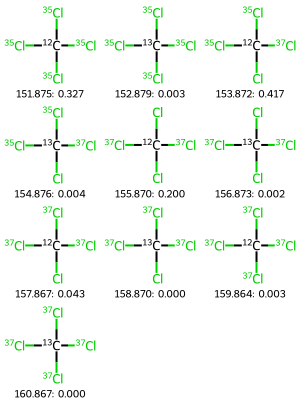

In [79]:
molecular_isotopes_flat = flatten_ndarray(molecular_isotopes)
masses_array_flat = list(extract_properties(molecular_isotopes_flat, "mass"))
order = np.argsort(masses_array_flat).tolist()

sorted_molecular_isotopes = sorted(molecular_isotopes_flat, key=lambda x: order.index(molecular_isotopes_flat.index(x)))
mols_flat_sorted = extract_properties(sorted_molecular_isotopes, "mol")
masses_flat_sorted = extract_properties(sorted_molecular_isotopes, "mass")
abundances_flat_sorted = extract_properties(sorted_molecular_isotopes, "abundance")
legends_flat = [f"{mass:.3f}: {abundance:.3f}" for mass, abundance in zip(masses_flat_sorted, abundances_flat_sorted)]

Chem.Draw.MolsToGridImage(mols_flat_sorted, legends=legends_flat, subImgSize=(100, 100)) #, legends=[str(mass) for mass in masses])